In [1]:
import torch
import torchvision as tv
import numpy as np
import matplotlib.pyplot as plt
from pytorch_resnet_cifar10 import resnet
import model_utils
import pruning

/home/zache1/anaconda3/envs/pyt/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# perform the same transform on all the data
transform = tv.transforms.Compose(
    [tv.transforms.ToTensor(), # scale the data between 0..1
     tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # normalize the data

# get the cifar10 data
data_train = tv.datasets.CIFAR10(root="data/CIFAR10/train", train=True, download=True, transform=transform)
data_test = tv.datasets.CIFAR10(root="data/CIFAR10/test", train=False, download=True, transform=transform)

# create the dataloaders for each dataset. These will be used for training and getting accuracy of a model
dataloader_train = torch.utils.data.DataLoader(data_train, batch_size=128, shuffle=False)
dataloader_test = torch.utils.data.DataLoader(data_test, batch_size=128, shuffle=False)

print(np.shape(data_test.data))

Files already downloaded and verified
Files already downloaded and verified
(10000, 32, 32, 3)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# these models will be ordered from most gradual to least
models = []

for _ in range(4):
    # Load the model
    model = resnet.resnet56()

    # load the model with the correct weights
    # must use DataParallel since the data was saved as a DataParallel
    torch.nn.DataParallel(model).load_state_dict(torch.load('pytorch_resnet_cifar10/pretrained_models/resnet56-4bfd9763.th', map_location=device)['state_dict'])

    model.to(device)

    model_utils.prepare_model(model)    

    models.append(model)

In [4]:
def train(model, epochs, dataloader):
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.0001)

    for i in range(epochs):
        for (images, labels) in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
        print("\t\tEpoch: {}".format(i))

Gradual Pruning: Prune 8 times
<br>120 epochs total => 15 epochs after each prune
<br>Target prune: 90% => 25.01% pruning per prune

Gradual Pruning: Prune 4 times
<br>120 epochs total => 30 epochs after each prune
<br>Target prune: 90% => 43.77% pruning per prune

Gradual Pruning: Prune 2 times
<br>120 epochs total => 60 epochs after each prune
<br>Target prune: 90% => 68.38% pruning per prune

Gradual Pruning: Prune 1 time
<br>120 epochs total => 120 epochs after each prune
<br>Target prune: 90% => 90% pruning per prune

In [5]:
times_pruned = np.array([8, 4, 2, 1])
epochs_per_prune = np.array([15, 30, 60, 120])
# epochs_per_prune = np.array([1, 2, 4, 8])
prune_percentage_per_prune = np.array([0.2501, 0.4377, 0.6838, 0.9])
accuracies = []
prune_percentages = []

for i, prune_times in enumerate(times_pruned):
    accuracy = np.zeros(prune_times)
    prune_percentage = np.zeros(prune_times)
    for prune in range(prune_times):
        print("Times to prune: {}\n\tTimes pruned: {}".format(prune_times, prune))
        pruning.global_mag_weight_prune(models[i], prune_percentage_per_prune[i])
        train(models[i], epochs_per_prune[i], dataloader_train)
        accuracy[prune] = model_utils.get_accuracy(models[i], dataloader_test, device)
        prune_percentage[prune] = model_utils.pruned_percentage(models[i], 'weight')
    accuracies.append(accuracy)
    prune_percentages.append(prune_percentage)

Times to prune: 8
	Times pruned: 0
		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch: 5
		Epoch: 6
		Epoch: 7
		Epoch: 8
		Epoch: 9
		Epoch: 10
		Epoch: 11
		Epoch: 12
		Epoch: 13
		Epoch: 14
Times to prune: 8
	Times pruned: 1
		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch: 5
		Epoch: 6
		Epoch: 7
		Epoch: 8
		Epoch: 9
		Epoch: 10
		Epoch: 11
		Epoch: 12
		Epoch: 13
		Epoch: 14
Times to prune: 8
	Times pruned: 2
		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch: 5
		Epoch: 6
		Epoch: 7
		Epoch: 8
		Epoch: 9
		Epoch: 10
		Epoch: 11
		Epoch: 12
		Epoch: 13
		Epoch: 14
Times to prune: 8
	Times pruned: 3
		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch: 5
		Epoch: 6
		Epoch: 7
		Epoch: 8
		Epoch: 9
		Epoch: 10
		Epoch: 11
		Epoch: 12
		Epoch: 13
		Epoch: 14
Times to prune: 8
	Times pruned: 4
		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch: 5
		Epoch: 6
		Epoch: 7
		Epoch: 8
		Epoch: 9
		Epoch: 10
		Epoch: 11
		Epoch: 12

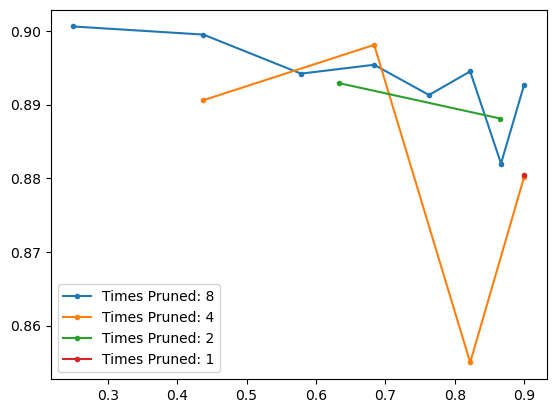

In [6]:
fig, axis = plt.subplots()

for i, prunes in enumerate(times_pruned):
    axis.plot(prune_percentages[i], accuracies[i], ".-", label="Times Pruned: {}".format(prunes))
    axis.legend()

In [7]:
accuracies

[array([0.9006, 0.8995, 0.8942, 0.8954, 0.8913, 0.8945, 0.882 , 0.8927]),
 array([0.8906, 0.8981, 0.855 , 0.8802]),
 array([0.8929, 0.8881]),
 array([0.8804])]

In [8]:
prune_percentages

[array([0.25009989, 0.43765042, 0.57829481, 0.68376311, 0.76285465,
        0.82216537, 0.86664254, 0.899996  ]),
 array([0.43769977, 0.68381835, 0.8222112 , 0.90002891]),
 array([0.63379931, 0.86589751]),
 array([0.89999953])]